In [1]:
import scipy.sparse as sparse
from qiskit.circuit.library import TwoLocal,RealAmplitudes
# from qiskit.algorithms.minimum_eigensolvers import VQE, NumPyMinimumEigensolver
# from qiskit.algorithms import VQE 
# from qiskit.primitives import Estimator,Sampler
from qiskit_aer.primitives import Estimator as Aer_Estimator
from qiskit_aer.primitives import Sampler as Aer_Sampler

from qiskit_aer.aerprovider import AerSimulator
# from qiskit.utils import QuantumInstance
# from qiskit.circuit.library import RealAmplitudes
# from qiskit_algorithms.optimizers import *
from qiskit.quantum_info.operators import Operator, SparsePauliOp
# from qiskit.opflow import OperatorBase
from qiskit.providers import Options
import time
import dill as pickle
from qiskit import QuantumCircuit
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import SPSA, COBYLA, L_BFGS_B
# from qiskit.opflow import MatrixOp
from qiskit_aer import AerSimulator, QasmSimulator

import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from utils import u_momentum, v_momentum, get_rhs, get_coeff_mat, pressure_correct,pressure_correct1,pressure_correct2, update_velocity, check_divergence_free


In [2]:
imax = 40                # grid size in x-direction
jmax = 40                # grid size in y-direction
num_qubits = 4
max_iteration = 2000             # iterations
max_res = 1000                   # initial residual
rho = 1                          # density
velocity = 1                     # velocity = lid velocity
Re = 100                         # Reynolds number
mu = 1/Re                        # kinematic viscosity = 1/Reynolds number
Lx = 1
Ly = 1
dx = Lx / (imax - 1)              # dx, dy cell sizes along x and y directions
dy = Ly / (jmax - 1)

x = np.arange(dx / 2, Lx, dx)
y = np.arange(0, Ly+dy/2, dy)
alpha_p = 0.1                    # pressure under-relaxation
alpha_u = 0.7                    # velocity under-relaxation
tol = 1e-5                       # tolerance for convergence

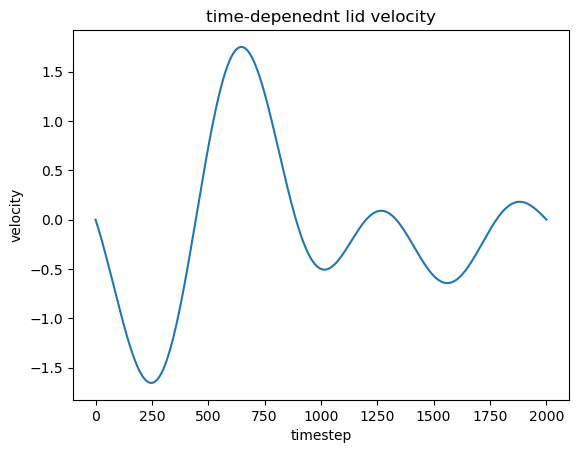

In [3]:
# Time-dependent boundary condition
x1 = np.linspace(0, 1, num = 2002)
x2 = np.linspace(1, 1.5, num = 2002)
time_dependent_velocity = (np.sin(2 * x1 * np.pi) - np.cos(x2 * np.pi)) * np.sin(3 * (x1 + x2) * np.pi)
plt.title("time-depenednt lid velocity")
plt.xlabel("timestep")
plt.ylabel("velocity")

plt.plot(time_dependent_velocity)

Iteration = 100; Residual = 0.008922522439408831


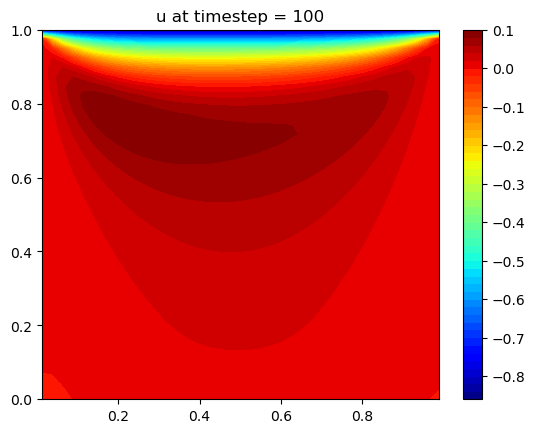

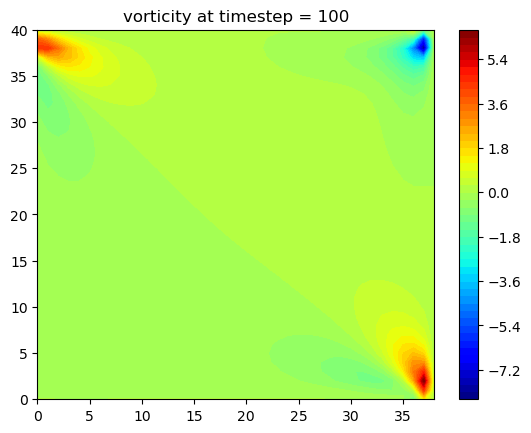

Iteration = 200; Residual = 0.004176089602367927


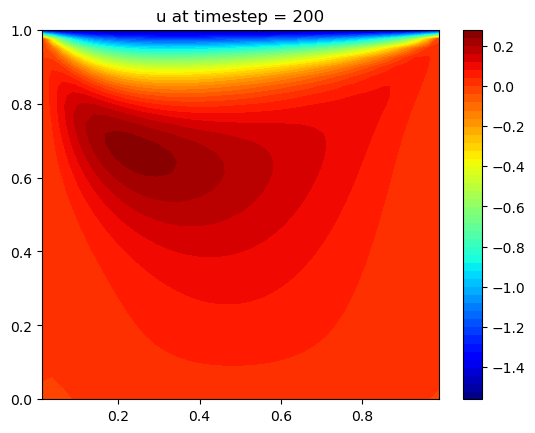

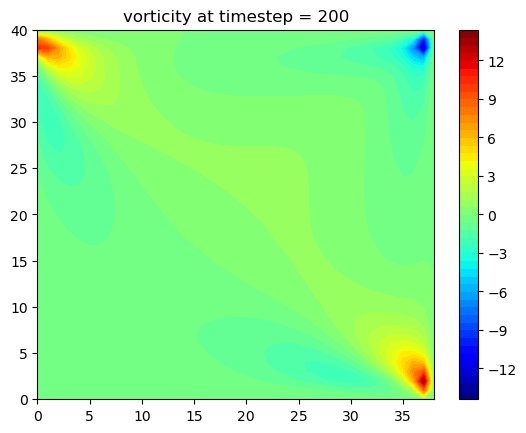

Iteration = 300; Residual = 0.005096461473944602


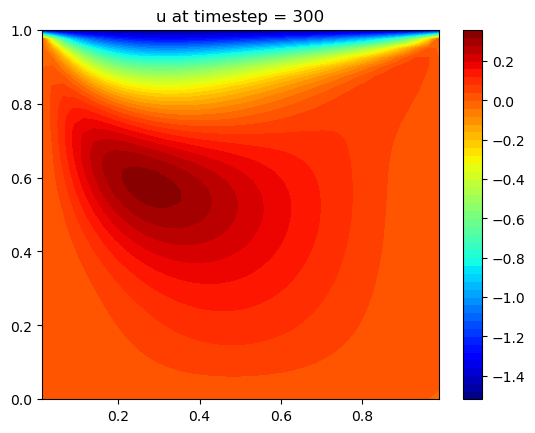

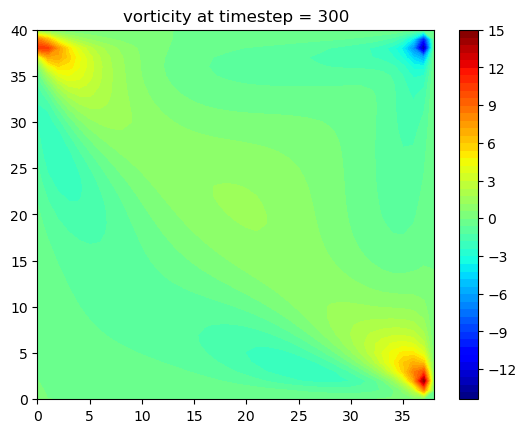

Iteration = 400; Residual = 0.012526144980115839


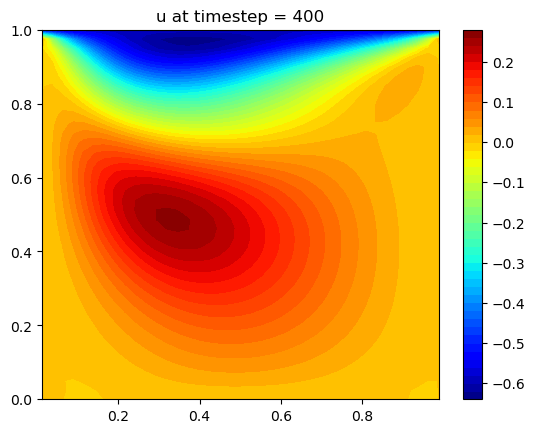

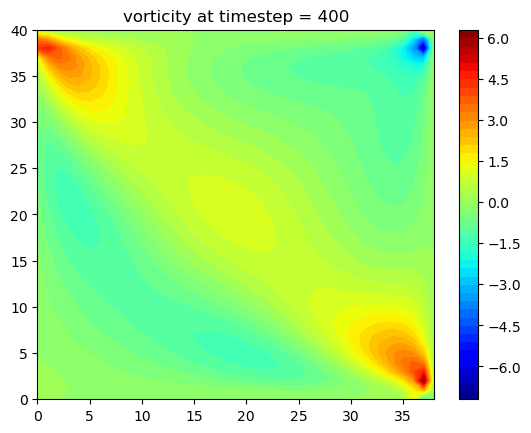

Iteration = 500; Residual = 0.012475926068224008


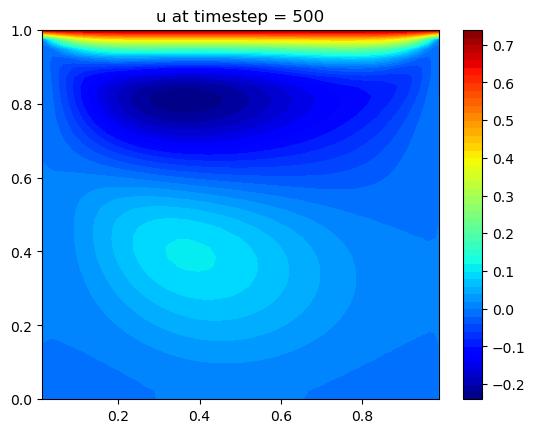

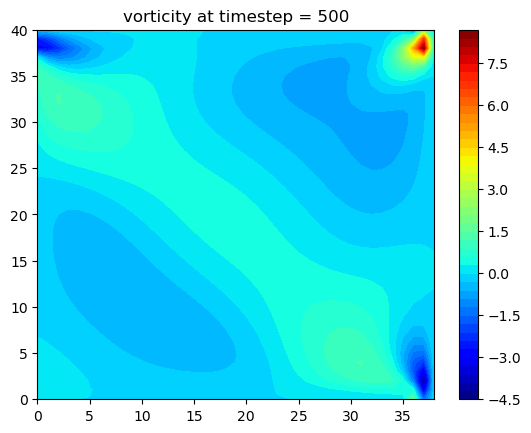

Iteration = 600; Residual = 0.005086726592913093


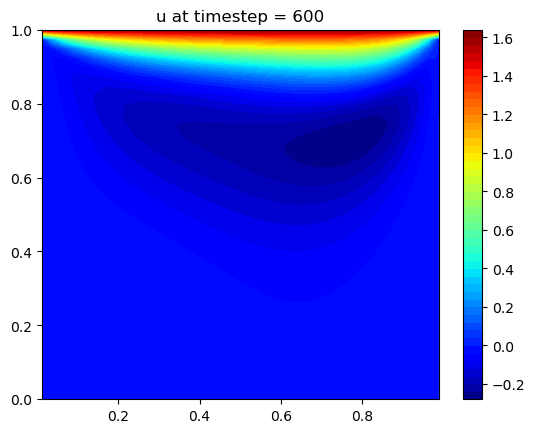

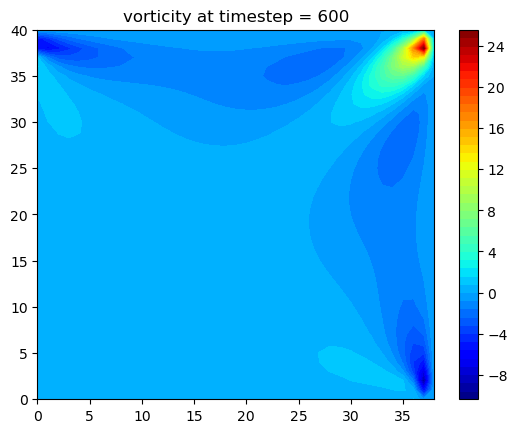

Iteration = 700; Residual = 0.004864606102135571


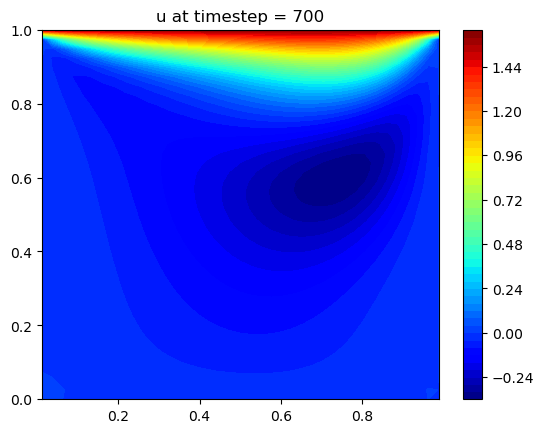

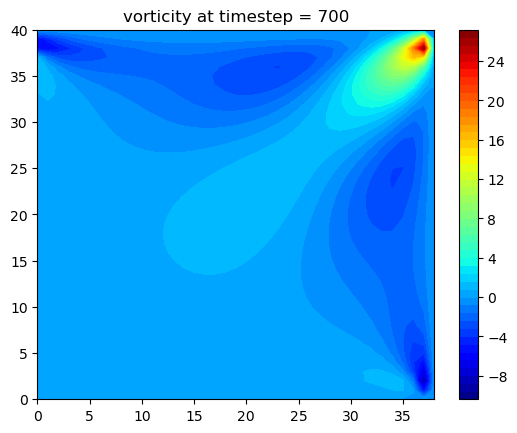

Iteration = 800; Residual = 0.009738468945352796


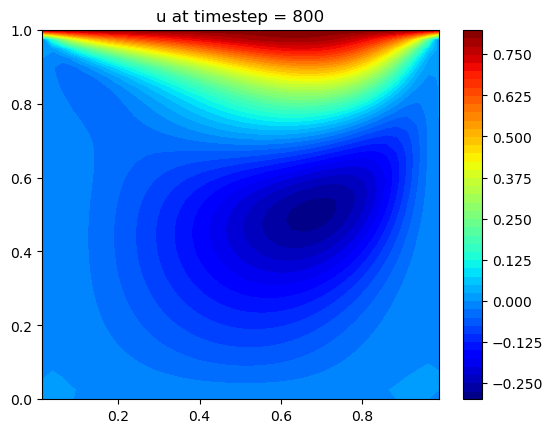

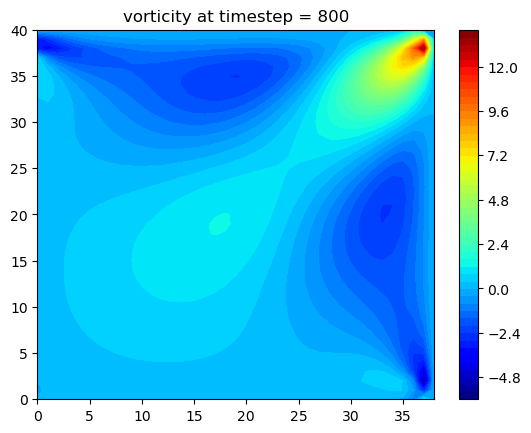

Iteration = 900; Residual = 0.007308756518701623


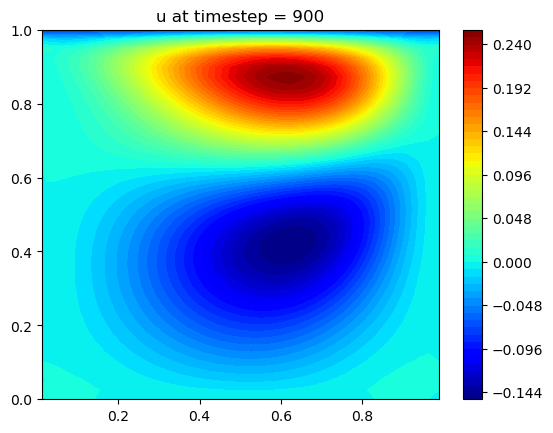

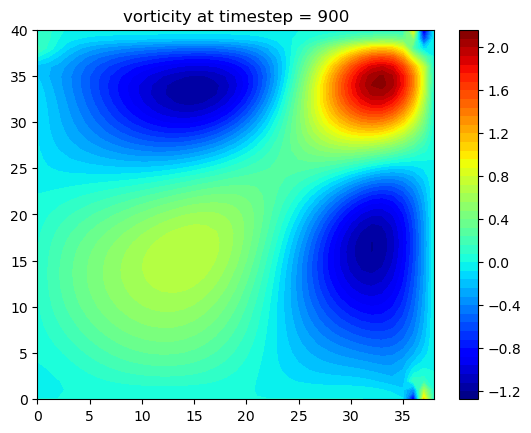

Iteration = 1000; Residual = 0.0021260530946355105


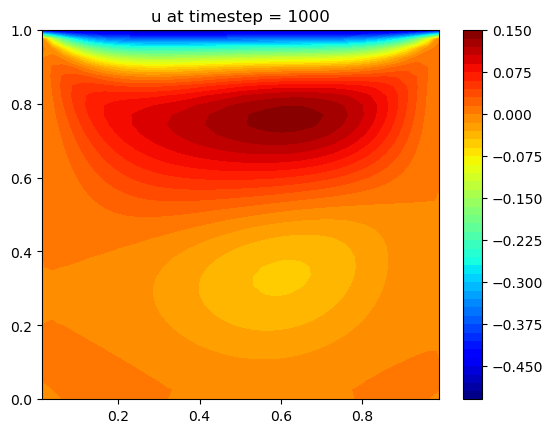

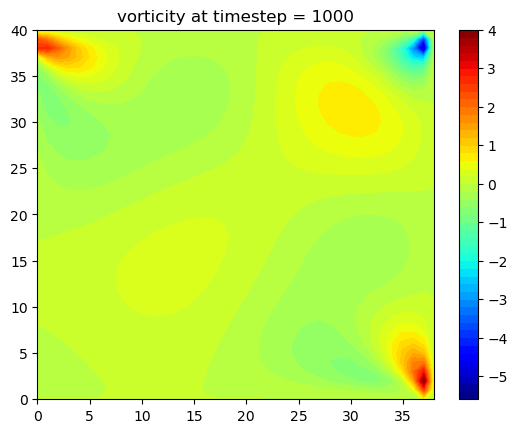

Iteration = 1100; Residual = 0.003363989396707956


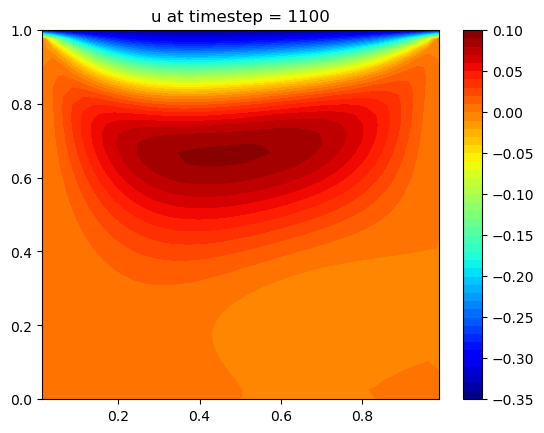

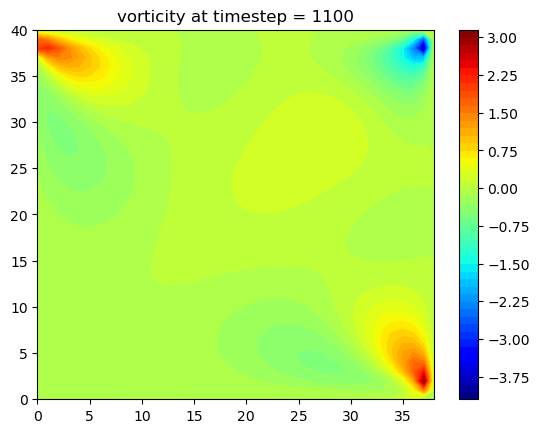

Iteration = 1200; Residual = 0.0026025906238041395


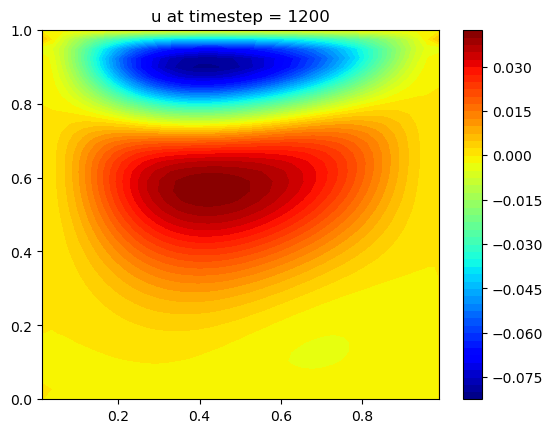

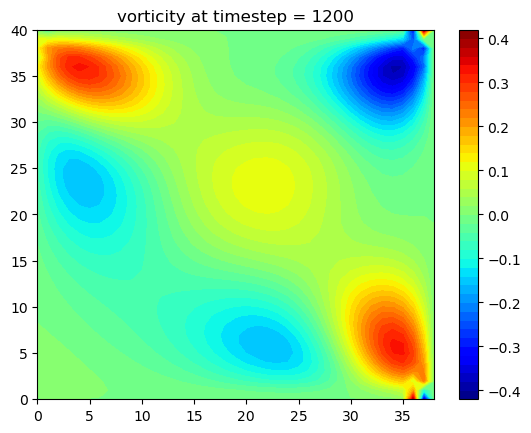

Iteration = 1300; Residual = 0.0013354782234731022


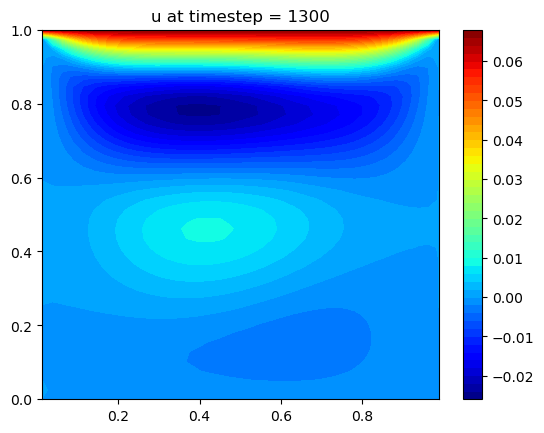

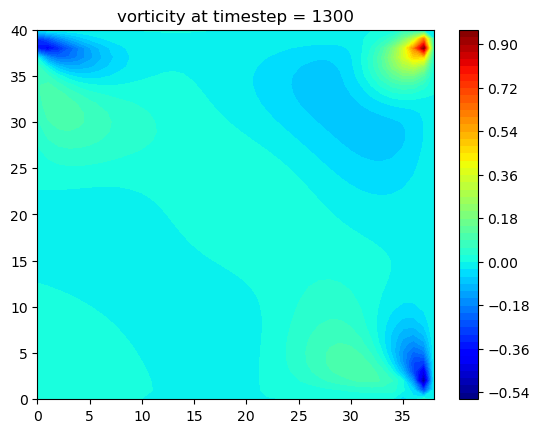

Iteration = 1400; Residual = 0.003879998006626445


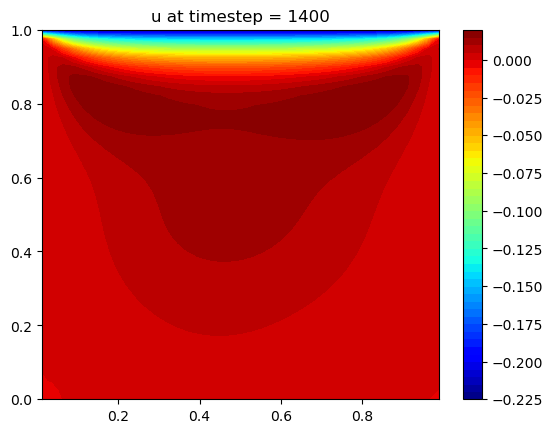

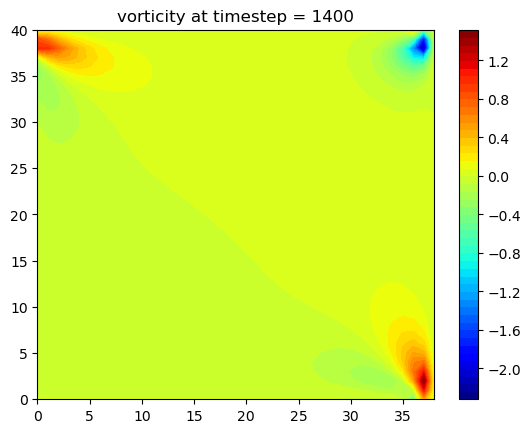

Iteration = 1500; Residual = 0.0023806491236780802


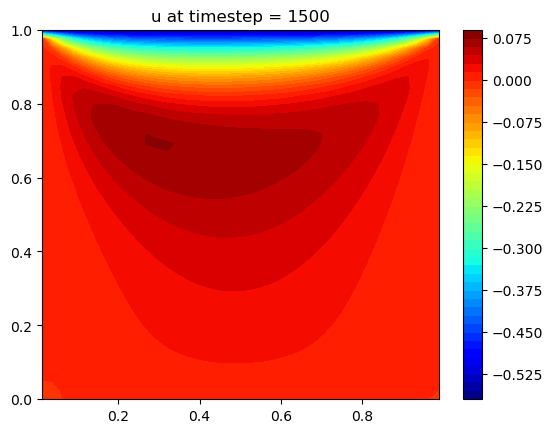

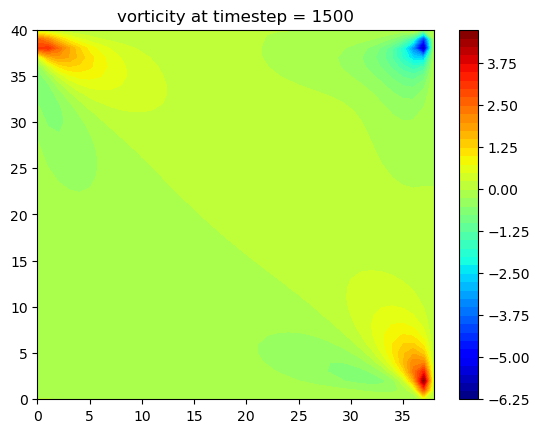

Iteration = 1600; Residual = 0.0015646388835489633


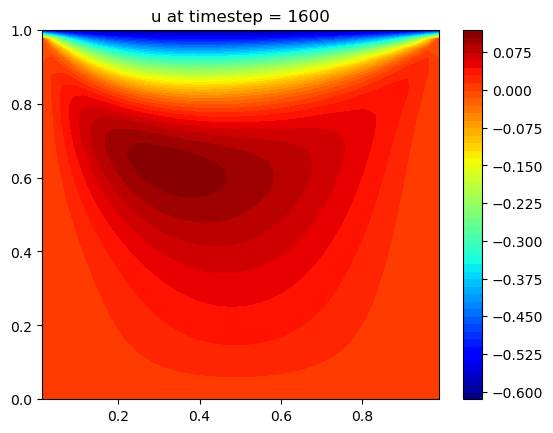

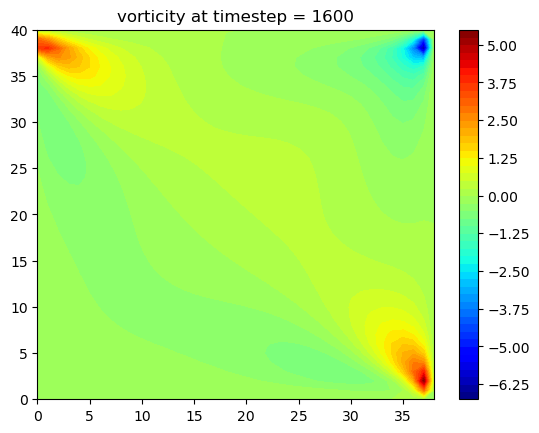

Iteration = 1700; Residual = 0.004024159826384099


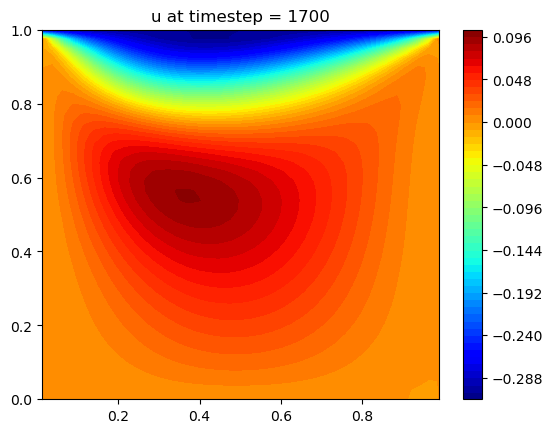

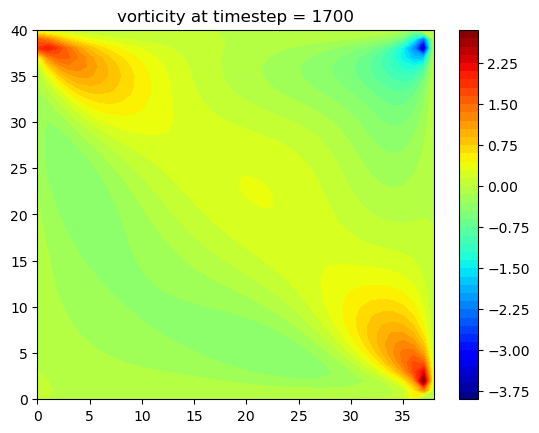

Iteration = 1800; Residual = 0.0027741078659691


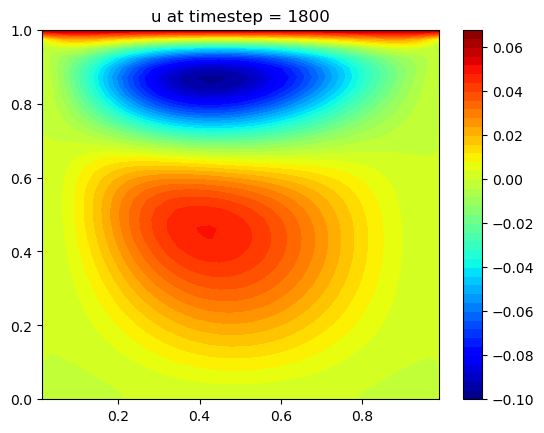

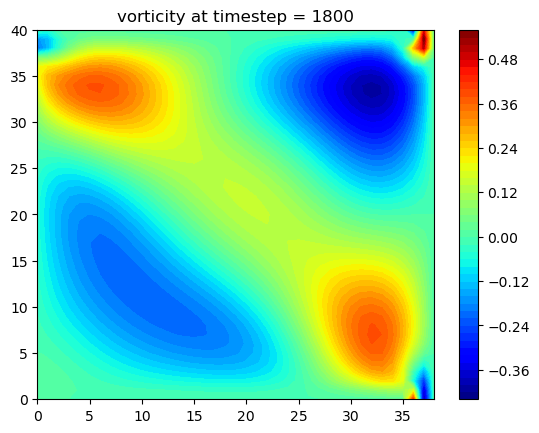

Iteration = 1900; Residual = 0.0006946288430994788


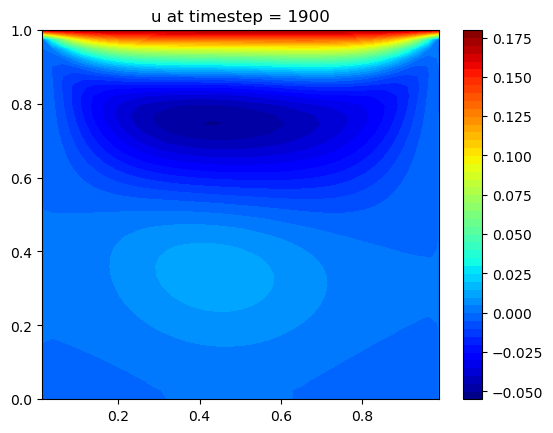

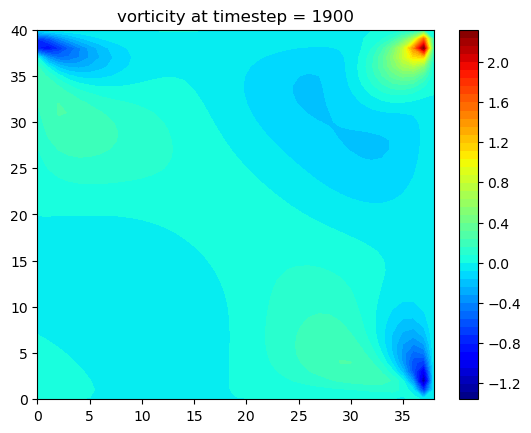

Iteration = 2000; Residual = 0.002354570010978457


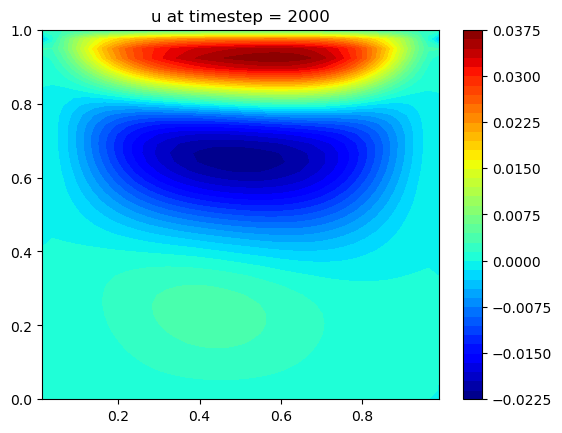

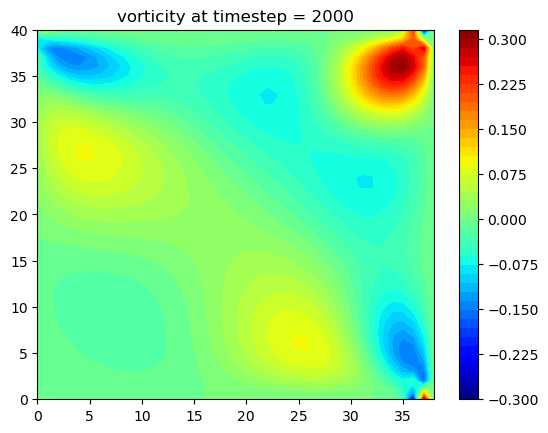

In [6]:
res_hist = []
div_list = []
max_res = 100
iteration = 1
# max_iteration = 10    # for debug
# Variable declaration
p = np.zeros((imax, jmax))             # p = Pressure
p_star = np.zeros((imax, jmax))        # intermediate pressure
p_prime = np.zeros((imax, jmax))       # pressure correction
rhsp = np.zeros((imax, jmax))          # right hand side vector of pressure correction equation
div = np.zeros((imax, jmax))

# Vertical velocity
v_star = np.zeros((imax, jmax + 1))    # intermediate velocity
v = np.zeros((imax, jmax + 1))         # final velocity
d_v = np.zeros((imax, jmax + 1))       # velocity correction coefficient

# Horizontal Velocity
u_star = np.zeros((imax + 1, jmax))    # intermediate velocity
u = np.zeros((imax + 1, jmax))         # final velocity
d_u = np.zeros((imax + 1, jmax))       # velocity correction coefficient


# Boundary condition
# Lid velocity (Top wall is moving with 1m/s)
u_star[:, jmax-1] = velocity
u[:, jmax-1] = velocity

num_qubits = 4
fid50 = []
while iteration <= max_iteration:
    iteration += 1
    
    # Solve u and v momentum equations for intermediate velocity 
    u_star, d_u = u_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, velocity, alpha_u)
    v_star, d_v = v_momentum(imax, jmax, dx, dy, rho, mu, u, v, p_star, alpha_u)

    u_old = u.copy()
    v_old = v.copy()

    # Calculate rhs vector of the Pressure Poisson matrix 
    rhsp = get_rhs(imax, jmax, dx, dy, rho, u_star, v_star)
    
    # Form the Pressure Poisson coefficient matrix 
    Ap = get_coeff_mat(imax, jmax, dx, dy, rho, d_u, d_v)
    
    p, p_prime = pressure_correct(imax, jmax, rhsp, Ap, p_star, alpha_p)
#     def pressure_correct_vqe(imax, jmax, rhsp, Ap, p, alpha, num_qubits, fid):
    
    # Update velocity based on pressure correction
    u, v = update_velocity(imax, jmax, u_star, v_star, p_prime, d_u, d_v, velocity, iteration, time_dependent_velocity)
    
    # Check if velocity field is divergence free
    div = check_divergence_free(imax, jmax, dx, dy, u, v)
    div_list.append(max(max(div.tolist())))    

    p_star = p.copy()              # use p as p_star for the next iteration

    # Find maximum residual in the domain
    v_res = np.abs(v - v_old)
    u_res = np.abs(u - u_old)
    max_res_u = np.max(u_res)
    max_res_v = np.max(v_res)
    max_res = max(max_res_u, max_res_v)
    res_hist.append(max_res)

    # Check for convergence  
    if (iteration % 100) == 0:
        print(f"Iteration = {iteration}; Residual = {max_res}")
        X, Y = np.meshgrid(x, y)
        plt.figure()
        plt.contourf(X, Y, u[1:imax,:].T, 50, cmap='jet')
        plt.colorbar()
        plt.title(f"u at timestep = {iteration}")
#         plt.axis([0, 1, 0, 1])
        plt.show()
        
        xnew = np.arange(0, 39, 1)
        ynew = np.arange(0, 41, 1)
        Xnew, Ynew = np.meshgrid(xnew, ynew)
        
        dvdx = np.gradient(v, dx, axis=1)
        dudy = np.gradient(u, dy, axis=0)
        curl = dvdx - np.transpose(dudy)
        plt.contourf(Xnew, Ynew, curl[1:imax,:].T, 50, cmap='jet')
        plt.colorbar()
        plt.title(f"vorticity at timestep = {iteration}")
        plt.show()
        
    
#     if max_res > 2:
#         print("not going to converge!")
#         break

In [ ]:
dvdx = np.gradient(v, dx, axis=1)
dudy = np.gradient(u, dy, axis=0)
curl = dvdx - np.transpose(dudy)
print(curl)

# x = np.arange(dx / 2, Lx, dx)
# y = np.arange(0, Ly+dy/2, dy)

xnew = np.arange(0, 3, 1)
ynew = np.arange(0, 5, 1)
Xnew, Ynew = np.meshgrid(xnew, ynew)

plt.contourf(Xnew, Ynew, curl[1:imax,:].T, 50, cmap='jet')
plt.colorbar()
plt.title(f"vorticity at timestep = {iteration}")
plt.show()

In [ ]:
print(v)
print(u)

In [ ]:
print(f"Final Iteration = {iteration}; Residual = {max_res}")
plt.semilogy(np.arange(len(res_hist)), res_hist, label = "velocity residual")
plt.semilogy(np.arange(len(div_list)), div_list, label = "divergence")
plt.legend()



In [ ]:

print(max(max(div_list[3].tolist())))

In [ ]:
print(u)
print(v)

In [ ]:
x = np.arange(dx / 2, Lx, dx)
y = np.arange(0, Ly+dy/2, dy)

X, Y = np.meshgrid(x, y)
plt.figure()
plt.contourf(X, Y, u[1:imax,:].T, 50, cmap='jet')
plt.colorbar()
# plt.axis([0, 1, 0, 1])
plt.title("Steady U")
plt.show()